In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scrnatools as rna
import numpy as np
from scipy.stats import spearmanr
import math

Global seed set to 0


In [2]:
sc.set_figure_params(figsize=(4,4), dpi=150, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
rna.configs.verbosity = "info"

# Data paths

## demeter

In [3]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

## gardner-lab-computer

In [4]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

# Import data

In [5]:
adata = sc.read(f"{processedDataPath}/human_ILC2/h5ad_files/human_merged_ILC_subset_3000_HVG.h5ad")

# Subset MS/LP score

In [10]:
MS_scoreV2 = ["AREG","FOS","CXCR4", "JUNB", "IL7R","TCF7","ADAM10","ZFP36L2","TSC22D3","CD69", "SPRY1","IER2", "BTG2","ATF3", "NFKBIA", "ZFP36", "TXNIP","NR4A1"]
MS_scoreV2 = [i for i in MS_scoreV2 if i in adata.var_names]
MS_scoreV2

['AREG',
 'FOS',
 'CXCR4',
 'JUNB',
 'IL7R',
 'TCF7',
 'ZFP36L2',
 'TSC22D3',
 'CD69',
 'SPRY1',
 'IER2',
 'BTG2',
 'ATF3',
 'NFKBIA',
 'ZFP36',
 'TXNIP',
 'NR4A1']

In [11]:
LP_scoreV2 = ["PTPN22","ELOVL5", "RORA", "EZR", "NEAT1","PTGES3", "ETS1", "REL","IRF1","PTGS2","IL15","AHR", "EPAS1","ADAM12", "IKZF3", "TNF", "DUSP6","LDLR","LITAF"]
LP_scoreV2 = [i for i in LP_scoreV2 if i in adata.var_names]
LP_scoreV2

['PTPN22',
 'ELOVL5',
 'RORA',
 'NEAT1',
 'PTGES3',
 'IRF1',
 'PTGS2',
 'IL15',
 'AHR',
 'EPAS1',
 'ADAM12',
 'IKZF3',
 'TNF',
 'DUSP6',
 'LDLR',
 'LITAF']

In [12]:
sc.tl.score_genes(adata, gene_list=LP_scoreV2, score_name="mouse_LP_subset_signature")
sc.tl.score_genes(adata, gene_list=MS_scoreV2, score_name="mouse_MS_subset_signature")

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


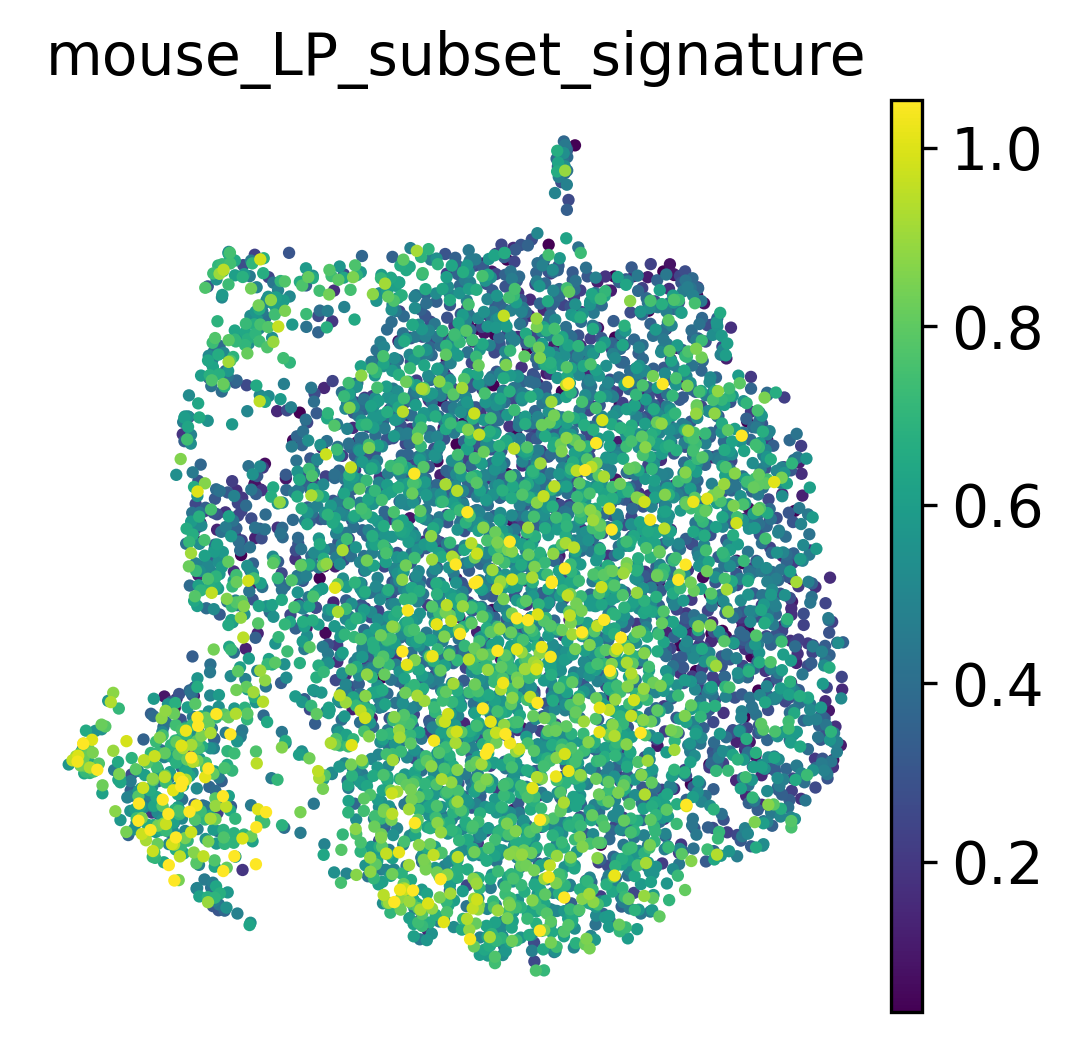

In [13]:
sc.settings.figdir = "../analysis"
sc.pl.umap(
    adata,
    color="mouse_LP_subset_signature",
    s=35,
    vmin = np.quantile(adata.obs.mouse_LP_subset_signature, 0.01),
    vmax = np.quantile(adata.obs.mouse_LP_subset_signature, 0.99),
    save="mouse_LP_subset_signature.pdf"
)

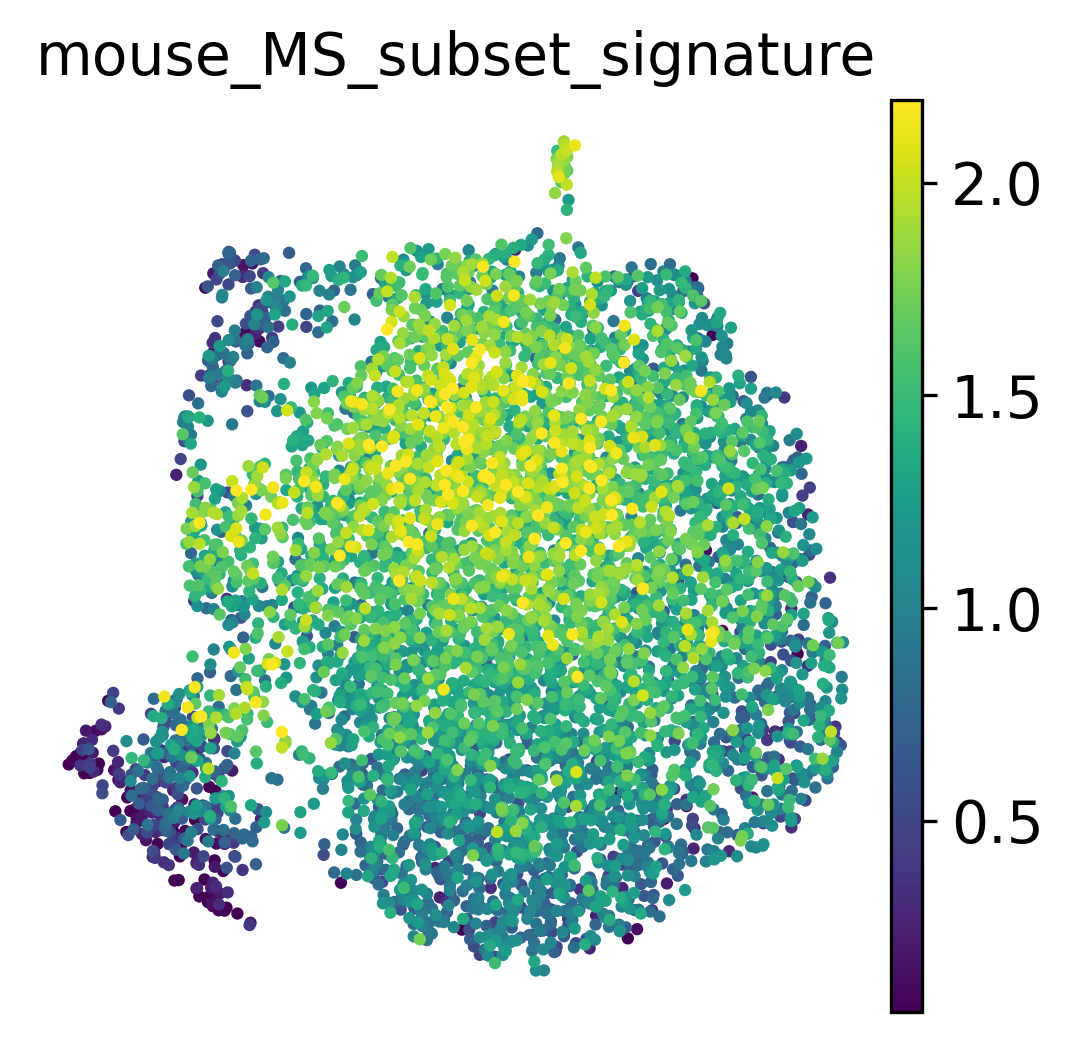

In [14]:
sc.pl.umap(
    adata,
    color="mouse_MS_subset_signature",
    s=35,
    vmin = np.quantile(adata.obs.mouse_MS_subset_signature, 0.01),
    vmax = np.quantile(adata.obs.mouse_MS_subset_signature, 0.99),
    save="mouse_MS_subset_signature.pdf"
)

## correlation to MS/LP density ratio

### MS

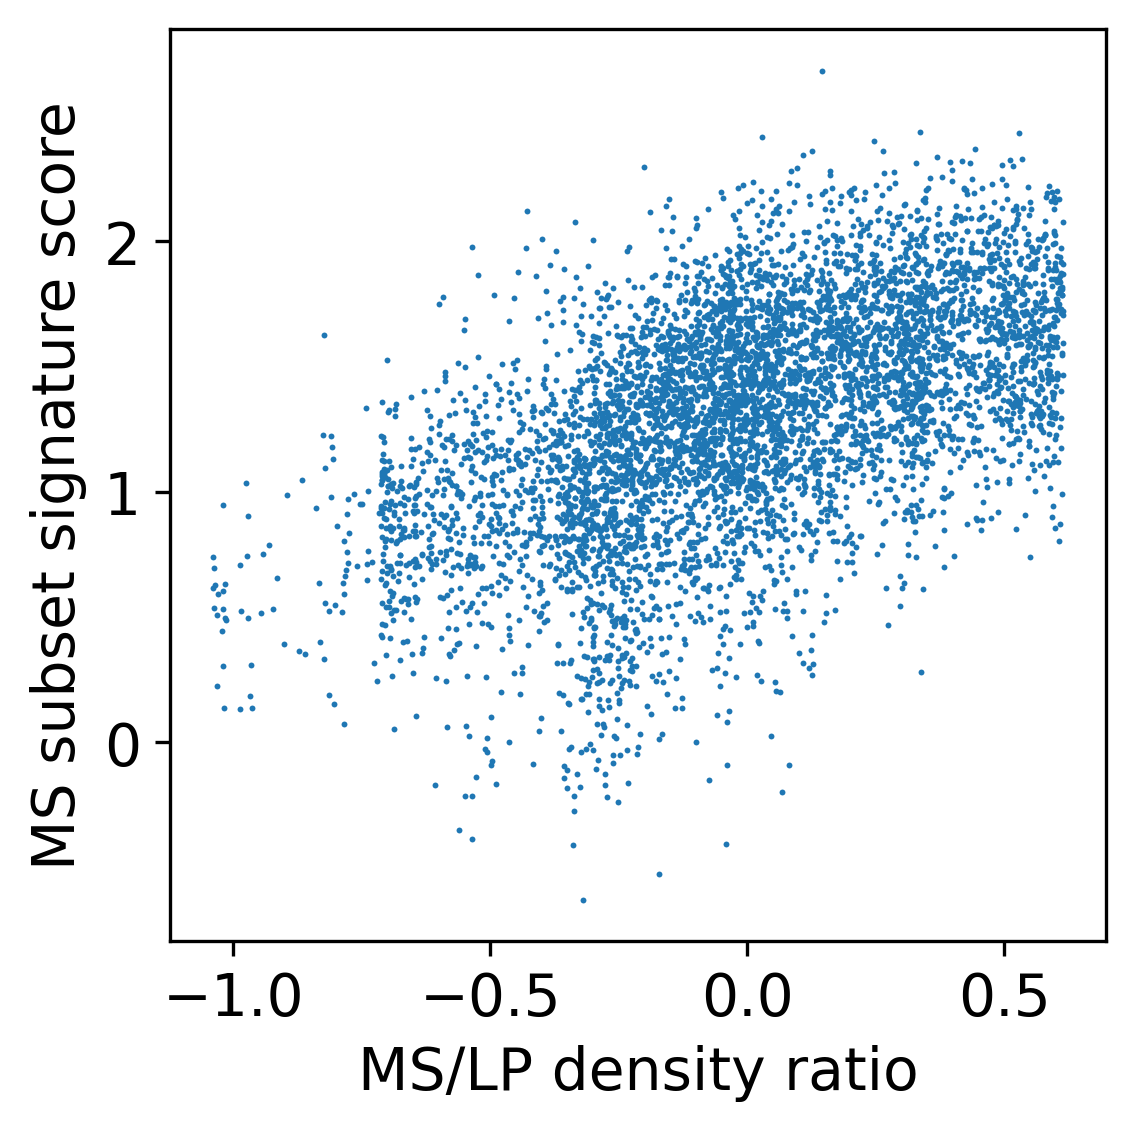

In [15]:
sns.scatterplot(
    x=adata.obs["MS/LP_log_density_ratio"],
    y=adata.obs.mouse_MS_subset_signature,
    s=2,
    linewidth=0,
)
plt.ylabel("MS subset signature score")
plt.xlabel("MS/LP density ratio")
plt.savefig("../analysis/MS_score_density_correlation.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [16]:
spearmanr(adata.obs["MS/LP_log_density_ratio"], adata.obs.mouse_MS_subset_signature)

SignificanceResult(statistic=0.5731561676216644, pvalue=0.0)

### LP

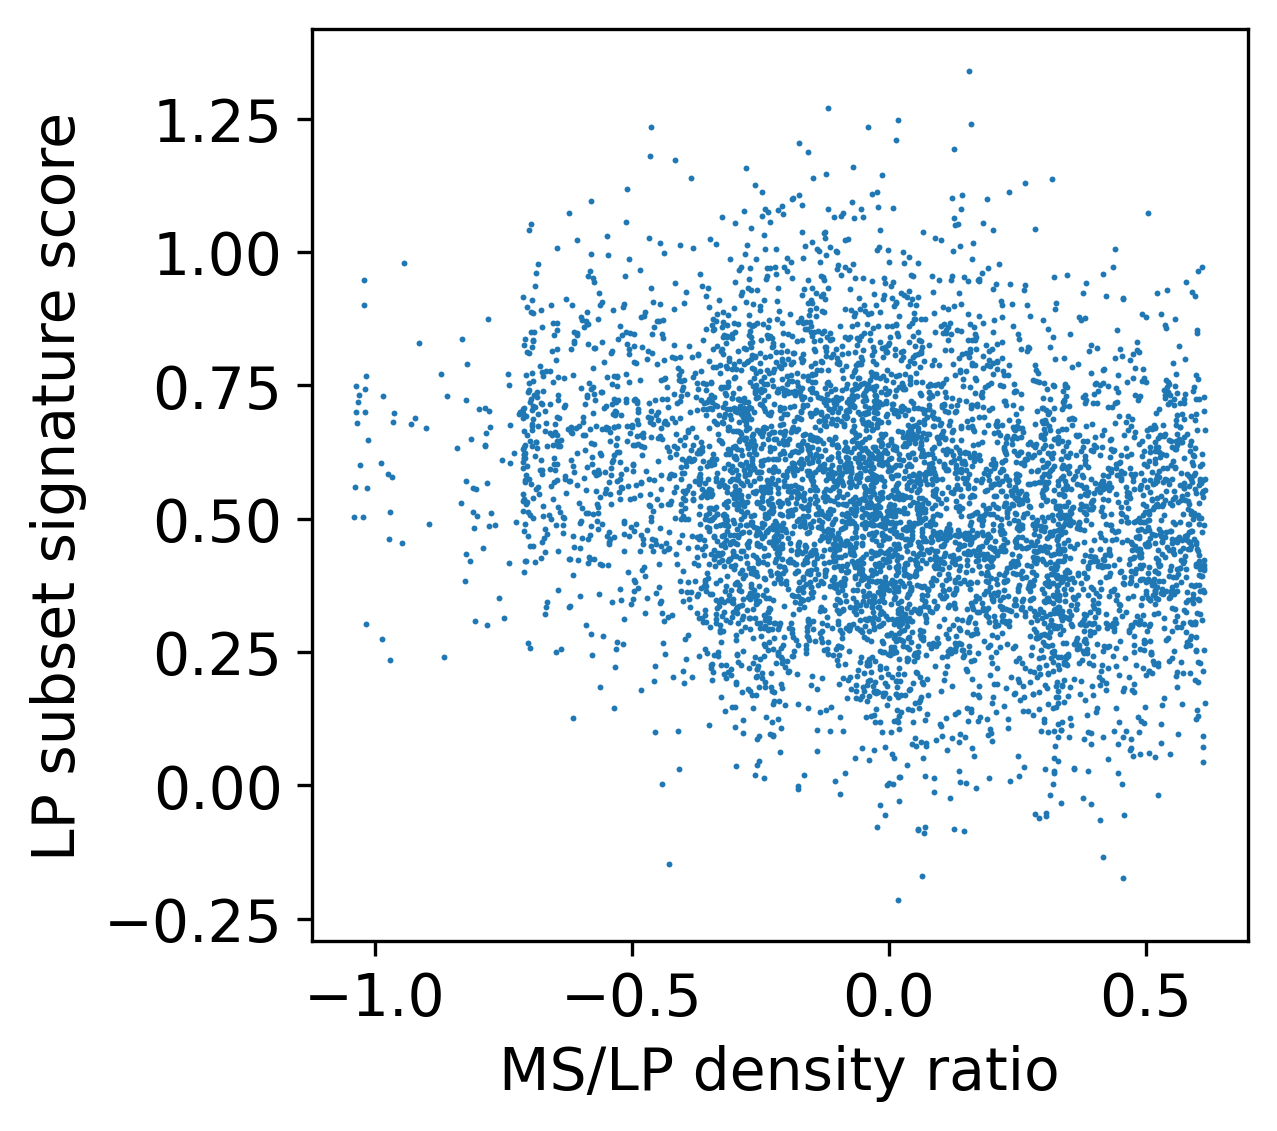

In [17]:
sns.scatterplot(
    x=adata.obs["MS/LP_log_density_ratio"],
    y=adata.obs.mouse_LP_subset_signature,
    s=2,
    linewidth=0,
)
plt.ylabel("LP subset signature score")
plt.xlabel("MS/LP density ratio")
plt.savefig("../analysis/LP_score_density_correlation.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [18]:
spearmanr(adata.obs["MS/LP_log_density_ratio"], adata.obs.mouse_LP_subset_signature)

SignificanceResult(statistic=-0.22961768490026985, pvalue=4.673719030169904e-72)

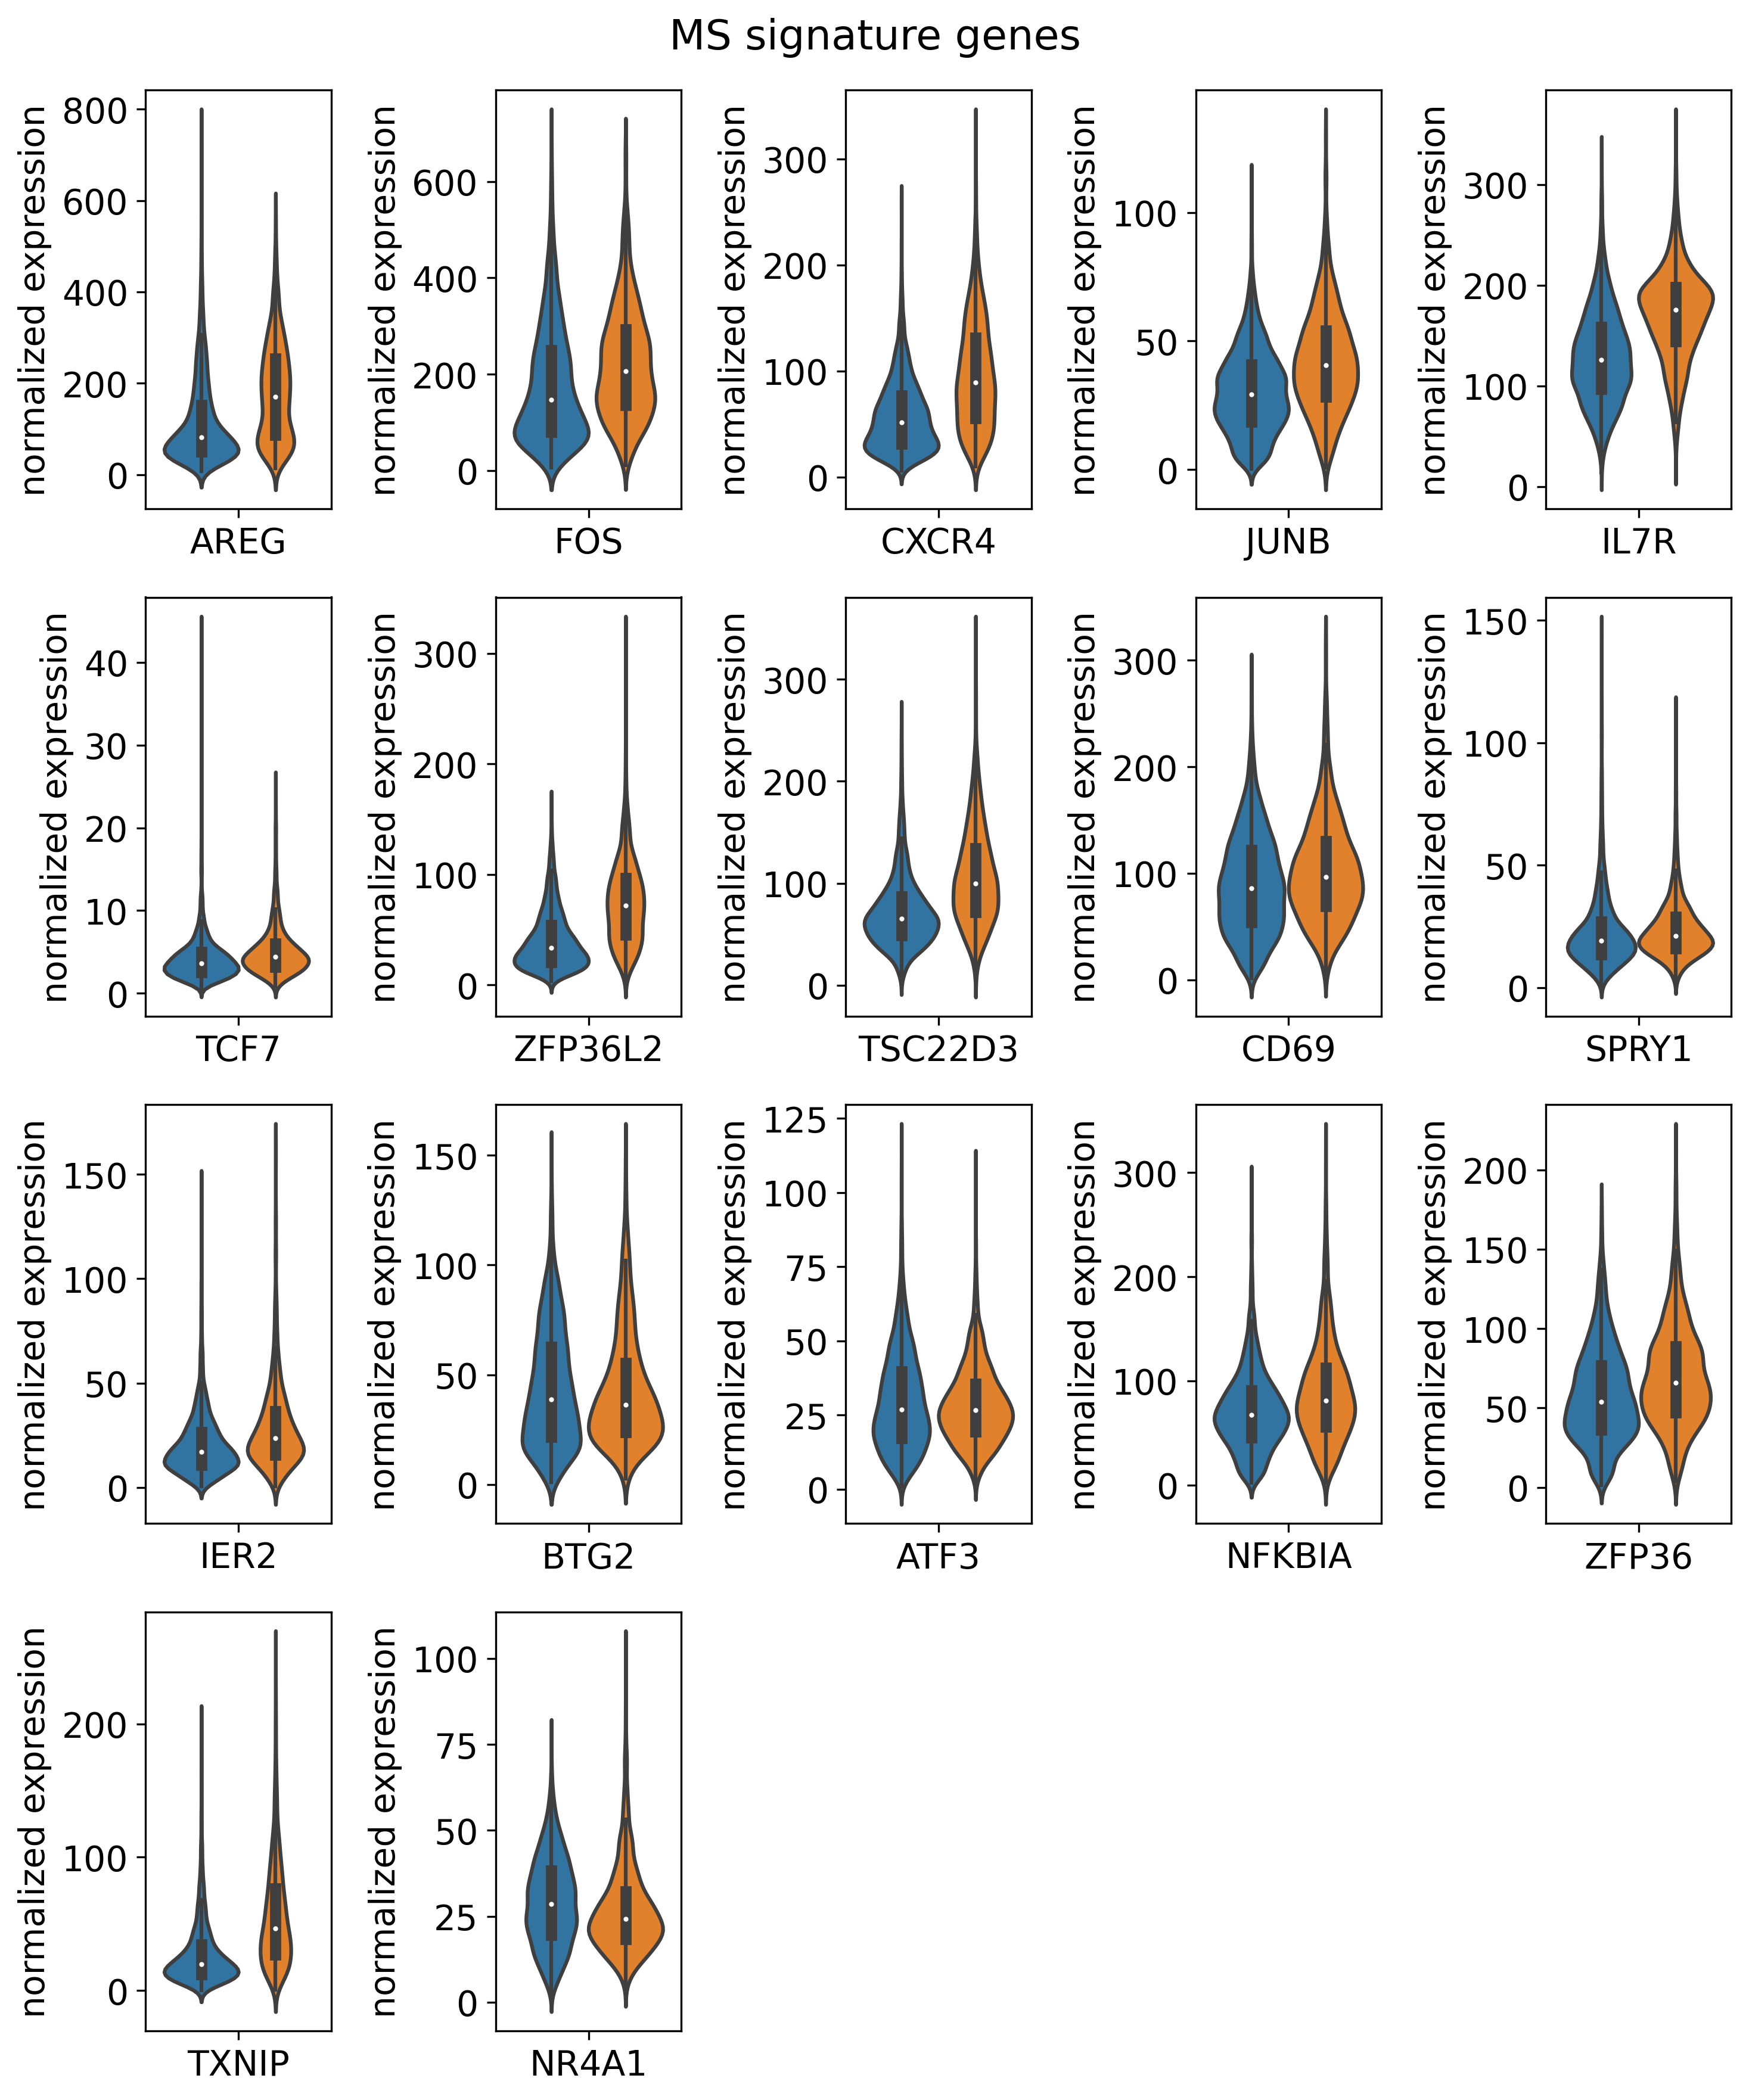

In [23]:
ncols = 5
nrows = math.ceil(len(MS_scoreV2)/ncols)
fig = plt.figure(figsize=(ncols*2,nrows*3))

for i,gene in enumerate(MS_scoreV2):
    plotData = pd.DataFrame(adata[:, gene].layers["scVI_normalized"], index=adata.obs.index, columns=[gene])
    plotData = plotData.melt()
    plotData["compartment"] = list(adata.obs.compartment)
    plt.subplot(nrows, ncols, i+1)
    ax = sns.violinplot(
        plotData,
        x="variable",
        y="value",
        hue="compartment"
    )
    plt.xlabel("")
    plt.ylabel("normalized expression")
    ax.get_legend().remove()
plt.suptitle("MS signature genes")
fig.tight_layout()
plt.savefig("../analysis/MS_signature_gene_violinplots.pdf", dpi=300)
plt.show()

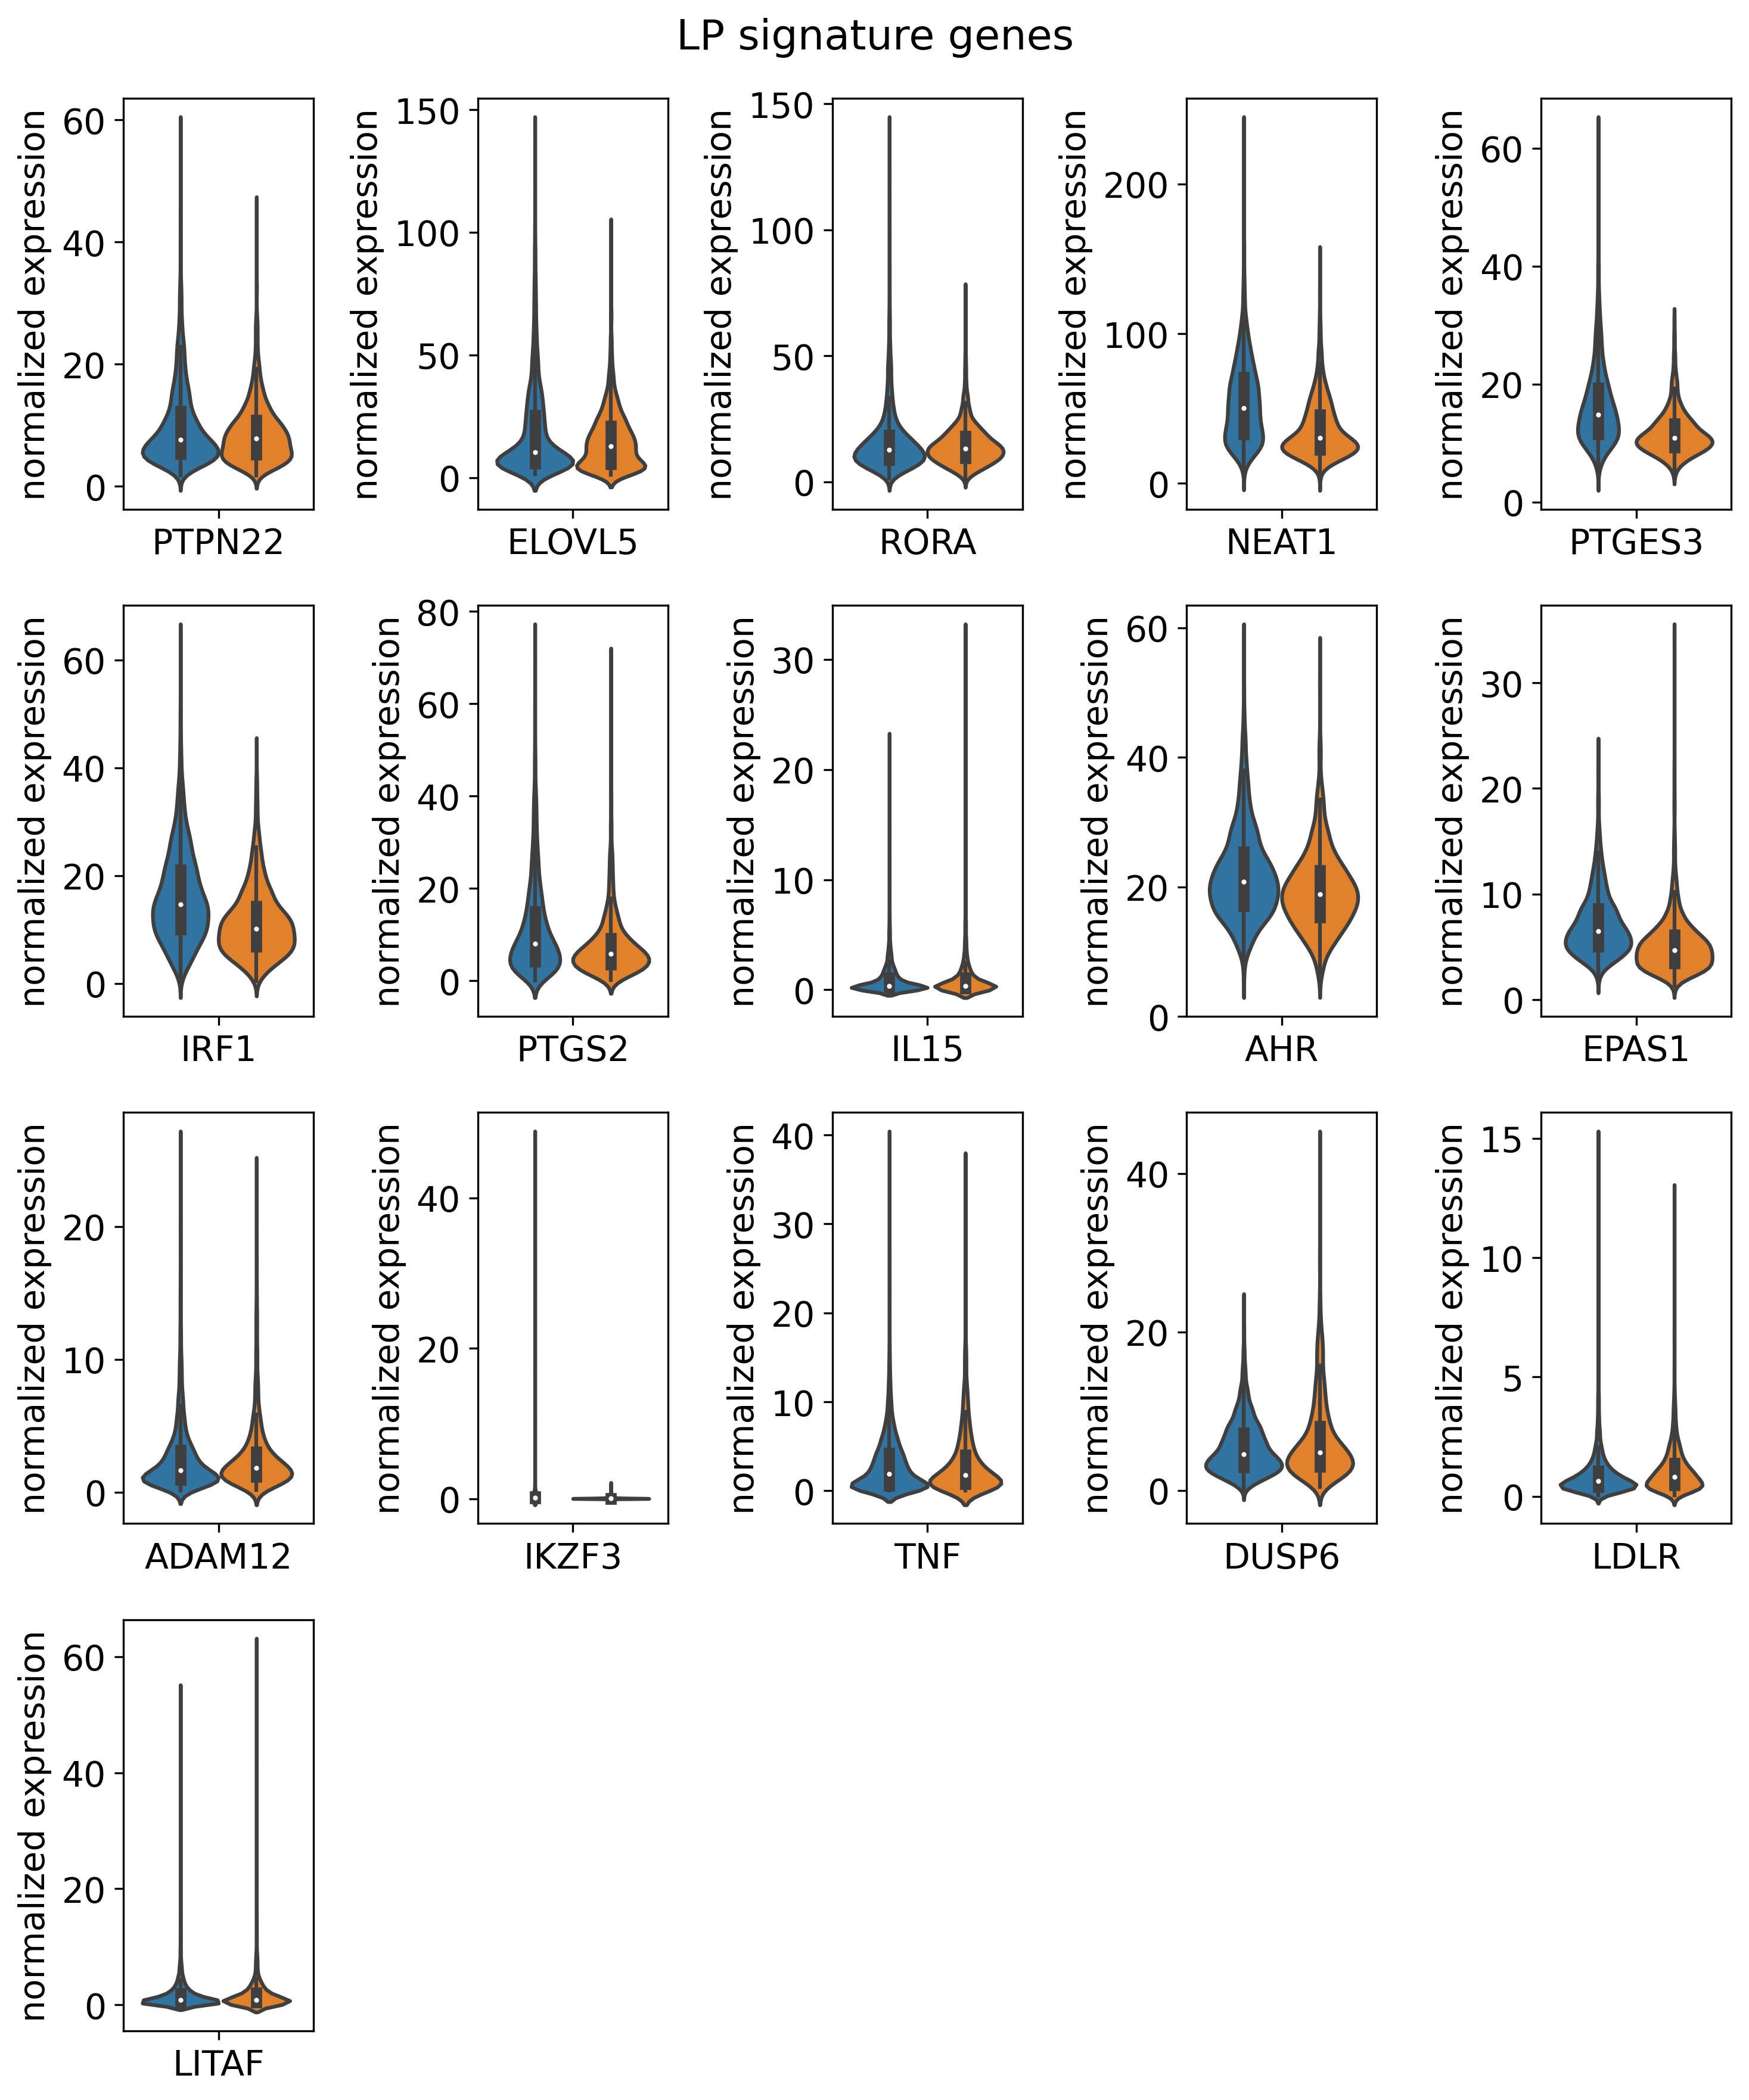

In [24]:
ncols = 5
nrows = math.ceil(len(LP_scoreV2)/ncols)
fig = plt.figure(figsize=(ncols*2,nrows*3))

for i,gene in enumerate(LP_scoreV2):
    plotData = pd.DataFrame(adata[:, gene].layers["scVI_normalized"], index=adata.obs.index, columns=[gene])
    plotData = plotData.melt()
    plotData["compartment"] = list(adata.obs.compartment)
    plt.subplot(nrows, ncols, i+1)
    ax = sns.violinplot(
        plotData,
        x="variable",
        y="value",
        hue="compartment"
    )
    plt.xlabel("")
    plt.ylabel("normalized expression")
    ax.get_legend().remove()
plt.suptitle("LP signature genes")
fig.tight_layout()
plt.savefig("../analysis/LP_signature_gene_violinplots.pdf", dpi=300)
plt.show()